**kaggle dataset** | https://www.kaggle.com/datasets/puneet6060/intel-image-classification |

# **Import libraries**

In [2]:
import glob
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import imshow
from matplotlib.image import imread
from sklearn.metrics import classification_report
from PIL import Image
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetV2B0, MobileNetV2
from tensorflow.keras.optimizers import Optimizer, Adam
from tensorflow.keras.utils import load_img
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix

# **Data Loading**

tadinya saya melakukan pengerjaan di google colab oleh karena itu saya melakukan data loading seperti yang dibawah tetapi saat sudah mendownload dan menunzip dataset saya pindah ke vscode oleh karena itu kodingan data loading tidak bisa dijalankan di vscode hanaya bisa dijalankan di google colab

In [4]:
!pip install -q kaggle

# Copy the Kaggle JSON file to the appropriate directory
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/GC7/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification -p /content/drive/MyDrive/GC7

In [6]:
!unzip -q /content/drive/MyDrive/GC7/intel-image-classification.zip -d /content/drive/MyDrive/GC7

# **EDA**

saya menampilkan setiap gambar yang ada di dalam kategori dataset yang saya miliki

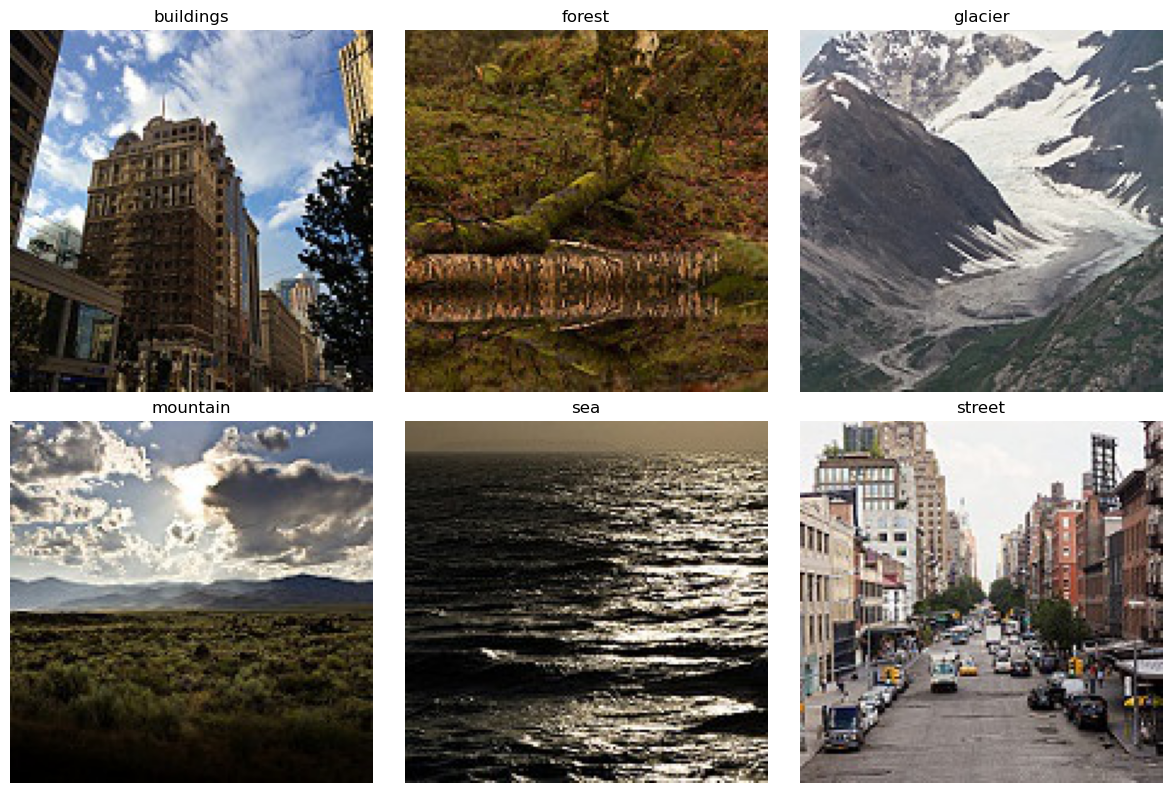

In [7]:

def show_image(ax, image):
    img_paths = glob.glob(os.path.join(train_path, image, '*'))
    if img_paths:
        i = np.random.randint(len(img_paths))
        img = Image.open(img_paths[i])
        ax.imshow(img)
        ax.set_title(image)
        ax.axis('off')  # Turn off axis labels for cleaner display

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Assuming train_path is defined earlier
train_path = 'D:\Hacktiv8\Phase 2\Week 1\p2-ftds009-hck-g7-habibibagus123\intel\seg_train\seg_train'

show_image(ax[0, 0], 'buildings')
show_image(ax[0, 1], 'forest')
show_image(ax[0, 2], 'glacier')
show_image(ax[1, 0], 'mountain')
show_image(ax[1, 1], 'sea')
show_image(ax[1, 2], 'street')

plt.tight_layout()
plt.show()

saya mencoba menampilkan scatter plot untuk melihat dimensi (panjang dan lebar) gambar pada setiap kategori yang ada di dataset

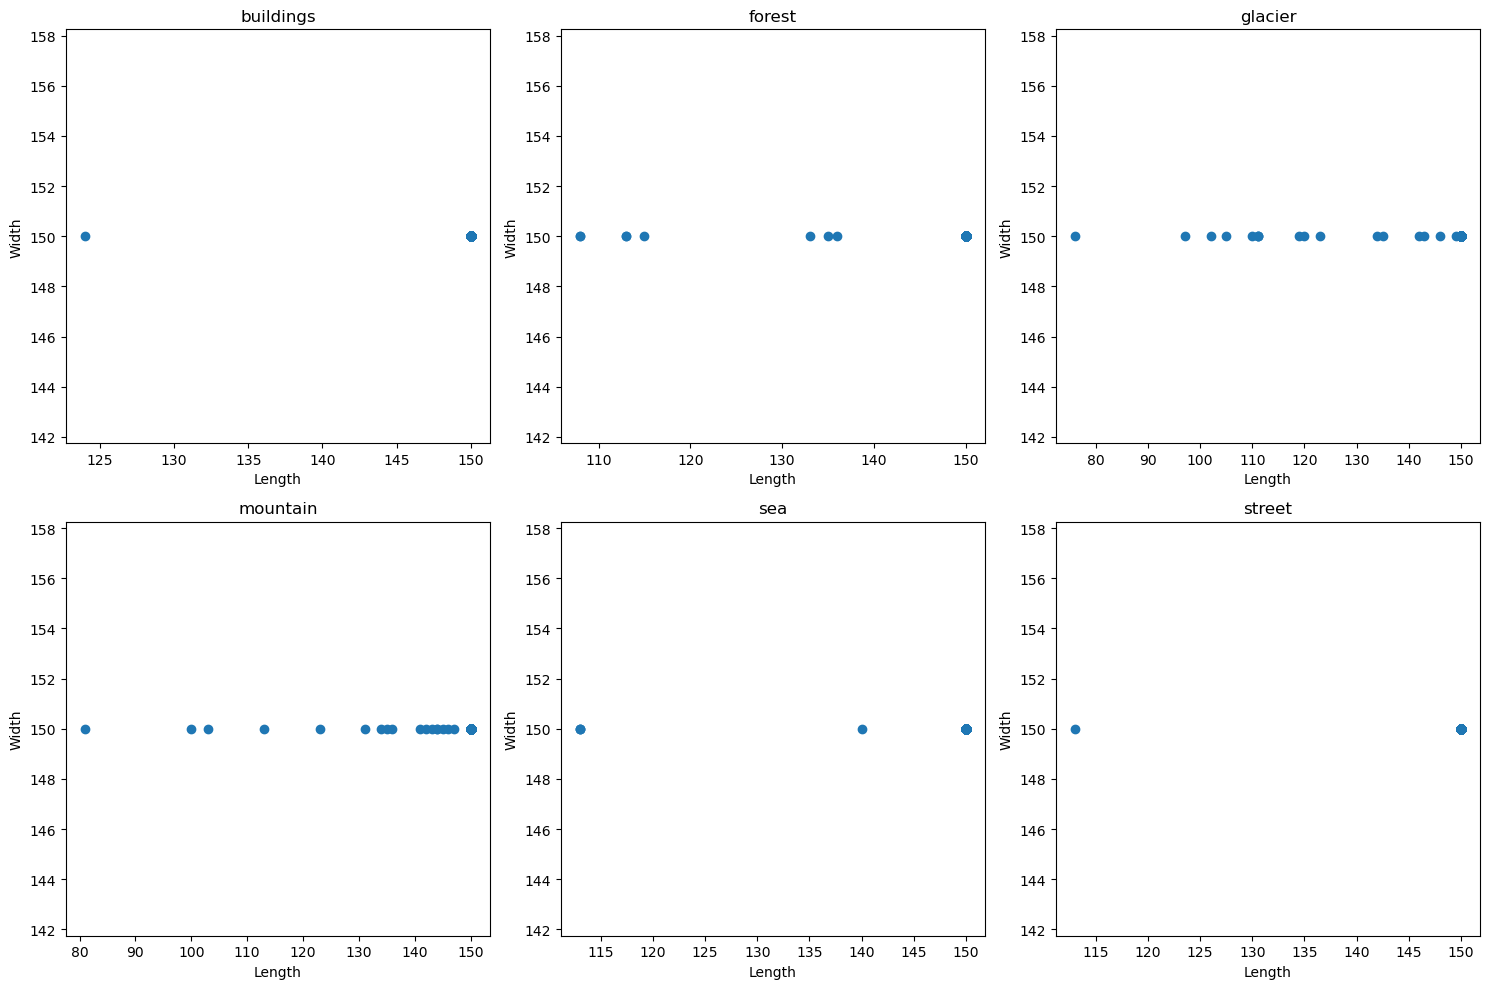

In [8]:

def plot_shape(image, ax):
    dim1 = []
    dim2 = []
    for image_filename in os.listdir(train_path[image]):
        img = imread(os.path.join(train_path[image], image_filename))
        d1, d2, _ = img.shape
        dim1.append(d1)
        dim2.append(d2)
    ax.scatter(dim1, dim2)
    ax.set_title(image)
    ax.set_xlabel('Length')
    ax.set_ylabel('Width')

train_path = {
    'buildings': r'D:\Hacktiv8\Phase 2\Week 1\p2-ftds009-hck-g7-habibibagus123\intel\seg_train\seg_train\buildings',
    'forest': r'D:\Hacktiv8\Phase 2\Week 1\p2-ftds009-hck-g7-habibibagus123\intel\seg_train\seg_train\forest',
    'glacier' : r'D:\Hacktiv8\Phase 2\Week 1\p2-ftds009-hck-g7-habibibagus123\intel\seg_train\seg_train\glacier',
    'mountain' : r'D:\Hacktiv8\Phase 2\Week 1\p2-ftds009-hck-g7-habibibagus123\intel\seg_train\seg_train\mountain',
    'sea' : r'D:\Hacktiv8\Phase 2\Week 1\p2-ftds009-hck-g7-habibibagus123\intel\seg_train\seg_train\sea',
    'street' : r'D:\Hacktiv8\Phase 2\Week 1\p2-ftds009-hck-g7-habibibagus123\intel\seg_train\seg_train\street'
    # Add other categories similarly
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
image_categories = list(train_path.keys())

for i in range(2):
    for j in range(3):
        if i * 3 + j < len(image_categories):
            plot_shape(image_categories[i * 3 + j], axes[i, j])
        else:
            axes[i, j].axis('off')  # Turn off empty subplots if there are fewer categories

plt.tight_layout()
plt.show()

# **Feature Engineering**

In [9]:
train_path = 'D:\Hacktiv8\Phase 2\Week 1\p2-ftds009-hck-g7-habibibagus123\intel\seg_train\seg_train'
test_path = 'D:\Hacktiv8\Phase 2\Week 1\p2-ftds009-hck-g7-habibibagus123\intel\seg_test\seg_test'

kode diatas saya melakukan augmentasi gambar dan mengatur fitur-fitur seperti normalisasi fitur, rotasi gambar, pergeseran horizonta dan vertikal pada gambar, skala rescaling, shearing gambar, zoom in dan zoom out gambar, flip gambar secara horizontal, dan fill mode

In [10]:
# image augmented
image_shape = (150,150,3)
batch_size = 64
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_gen = datagen.flow_from_directory(train_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical',shuffle=True)
test_gen = datagen.flow_from_directory(test_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical',shuffle=False)
train_gen.class_indices

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [11]:
print(train_gen.class_indices)
print(test_gen.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


# **Model Definition**

#### **CNN**

dalam model cnn saya mengkalsifikasikan gambar dari beberapa kategori dan model cnn saya terdiri dari beberapa layer yang berbeda yaitu 2 layer Conv2D untuk mengekstraksi fitur dari gambar, 2 layer Maxpooling2D untuk mereduksi ukuran gambar dan mencegah overfitting, flatten meratakkan output menjadi satu dimensi, dense yang memiliki 128 neuron, dropout untuk mencegah overfitting, dan output layer dari 6 neurong

In [12]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=8)
model.fit(train_gen, validation_data=test_gen, epochs=20,steps_per_epoch=20, callbacks=[es])

Epoch 1/20
20/20 [==============================] - 78s 4s/step - loss: 7.5803 - accuracy: 0.2398 - val_loss: 1.7294 - val_accuracy: 0.2800
Epoch 2/20
20/20 [==============================] - 49s 3s/step - loss: 1.6526 - accuracy: 0.2680 - val_loss: 1.6212 - val_accuracy: 0.3130
Epoch 3/20
20/20 [==============================] - 49s 2s/step - loss: 1.5191 - accuracy: 0.3664 - val_loss: 1.4321 - val_accuracy: 0.3950
Epoch 4/20
20/20 [==============================] - 50s 3s/step - loss: 1.2923 - accuracy: 0.4969 - val_loss: 1.2578 - val_accuracy: 0.4790
Epoch 5/20
20/20 [==============================] - 49s 3s/step - loss: 1.1438 - accuracy: 0.5186 - val_loss: 1.2535 - val_accuracy: 0.4710
Epoch 6/20
20/20 [==============================] - 50s 3s/step - loss: 1.1475 - accuracy: 0.5148 - val_loss: 1.1482 - val_accuracy: 0.5347
Epoch 7/20
20/20 [==============================] - 50s 3s/step - loss: 1.1369 - accuracy: 0.5547 - val_loss: 1.0429 - val_accuracy: 0.5870
Epoch 8/20
20/20 [==

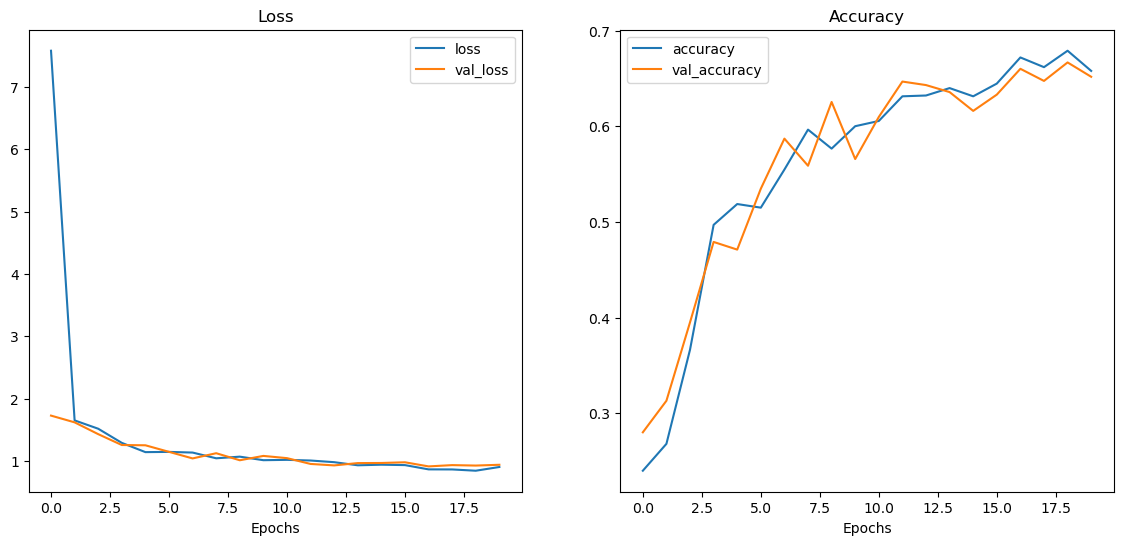

In [13]:
# plot the results
fig, ax = plt.subplots(1,2, figsize=(14,6))
pd.DataFrame(model.history.history)[['loss','val_loss']].plot(ax = ax[0])
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot(ax = ax[1])
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs');

In [14]:
# evaluate model
loss, accuracy = model.evaluate(test_gen)

47/47 [==============================] - 23s 484ms/step - loss: 0.9251 - accuracy: 0.6597


akurasi yang didapat dari model cnn adalah sebessar 65% 

# **Model Training**

dikarenakan hasil dari model cnn tidak memuaskan asya melkakuan model improvment dengan transfer learning dengan arsitektur MobileNetV2 

#### **Transfer Learning**

In [15]:
# try MobileNet
image_shape = (224,224,3)
batch_size = 128
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_gen = datagen.flow_from_directory(train_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical', shuffle=True)
test_gen = datagen.flow_from_directory(test_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical', shuffle=False)

mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)
for layer in mobile.layers[:-4]:
    layer.trainable = False

x = mobile.output
x = GlobalAveragePooling2D()(x)
output = Dense(6, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
model.fit(train_gen, validation_data=test_gen, epochs=20, steps_per_epoch=20, callbacks=[es])

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/20
20/20 [==============================] - 184s 9s/step - loss: 0.7380 - accuracy: 0.7287 - val_loss: 0.5519 - val_accuracy: 0.7977
Epoch 2/20
20/20 [==============================] - 170s 9s/step - loss: 0.3511 - accuracy: 0.8691 - val_loss: 0.4720 - val_accuracy: 0.8290
Epoch 3/20
20/20 [==============================] - 164s 8s/step - loss: 0.3372 - accuracy: 0.8799 - val_loss: 0.4427 - val_accuracy: 0.8353
Epoch 4/20
20/20 [==============================] - 165s 8s/step - loss: 0.3087 - accuracy: 0.8902 - val_loss: 0.4482 - val_accuracy: 0.8343
Epoch 5/20
20/20 [==============================] - 166s 8s/step - loss: 0.2741 - accuracy: 0.8986 - val_loss: 0.4201 - val_accuracy: 0.8427
Epoch 6/20
20/20 [==============================] - 159s 8s/step - loss: 0.2939 - accuracy: 0.8953 - val_loss: 0.4488 - val_accuracy: 0.8343
Epoch 7/20
20/20 [==============================] - 160s 8s/step - lo

<Axes: >

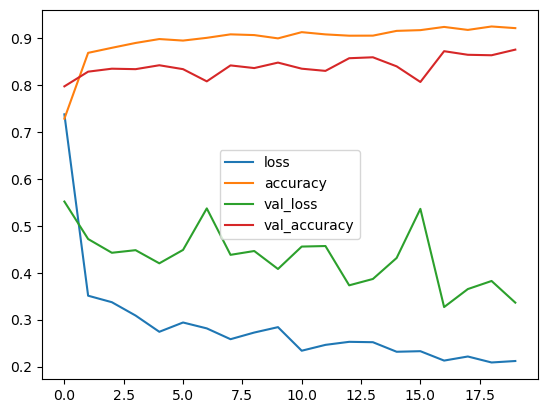

In [16]:
pd.DataFrame(model.history.history).plot()

In [17]:
loss, accuracy = model.evaluate(test_gen)

24/24 [==============================] - 90s 4s/step - loss: 0.3511 - accuracy: 0.8697


setelah melakukan fine-tunning didapatkan hasil akurasi meningkat yaitu menjadi 86%

# **Model Evaluation**

In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen_new = test_datagen.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    batch_size=batch_size,
    shuffle=False  
)
y_pred = model.predict(test_gen_new)
y_pred_label = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

acc = accuracy_score(y_true, y_pred_label)
print(f"Predicted accuracy: {acc}")

Found 3000 images belonging to 6 classes.
24/24 [==============================] - 78s 3s/step
Predicted accuracy: 0.8886666666666667


saya melakukan prediksi model yang telah dilatih sebelumnya dan didapatkan akus=rasi sebesar 88%

terlihat dari heatmap yang ada bahwa banyak hasil prediksi dan data sbenarnya yang tidak cocok salah satunya adalah street dengan kesalahan 80 gambar

Text(0.5, 1.0, 'Confusion Matrix')

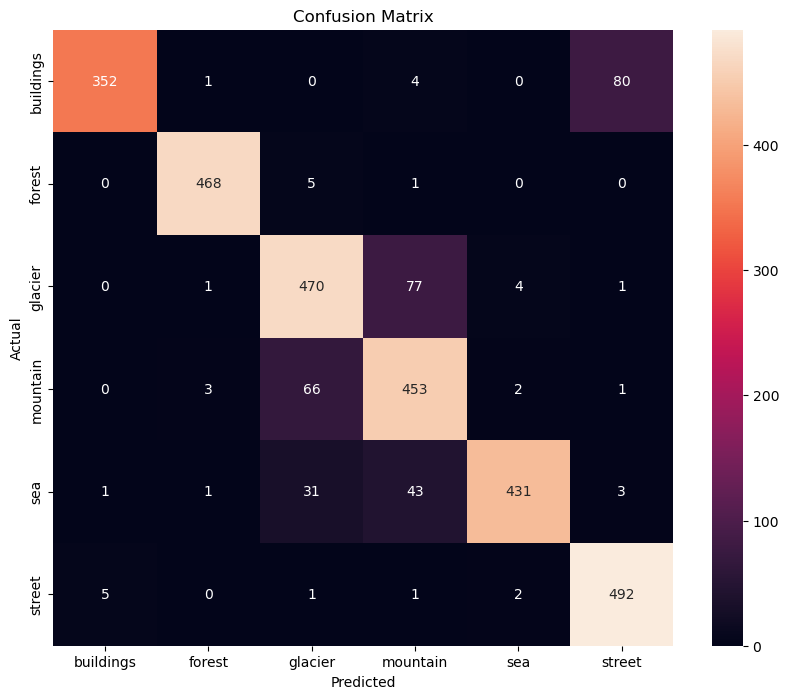

In [19]:
cm = confusion_matrix(y_true, y_pred_label)
class_names = list(train_gen.class_indices.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

In [20]:
# y_true adalah label yang benar, y_pred_label adalah label yang diprediksi
# Gunakan classification_report untuk mendapatkan laporan klasifikasi
report = classification_report(y_true, y_pred_label, target_names=class_names)

print(report)

              precision    recall  f1-score   support

   buildings       0.98      0.81      0.89       437
      forest       0.99      0.99      0.99       474
     glacier       0.82      0.85      0.83       553
    mountain       0.78      0.86      0.82       525
         sea       0.98      0.85      0.91       510
      street       0.85      0.98      0.91       501

    accuracy                           0.89      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.90      0.89      0.89      3000



saya memperlihatkan gambar yang salah di prediksi seperti yang ada di heatmap confussion matrix diatas bisa dilihat gambar terdapat kelasahan prediksi dikarenakan gambar tidak jelas atau terhalang sesuatu oleh karena itu prediksi jadi tidak akurat

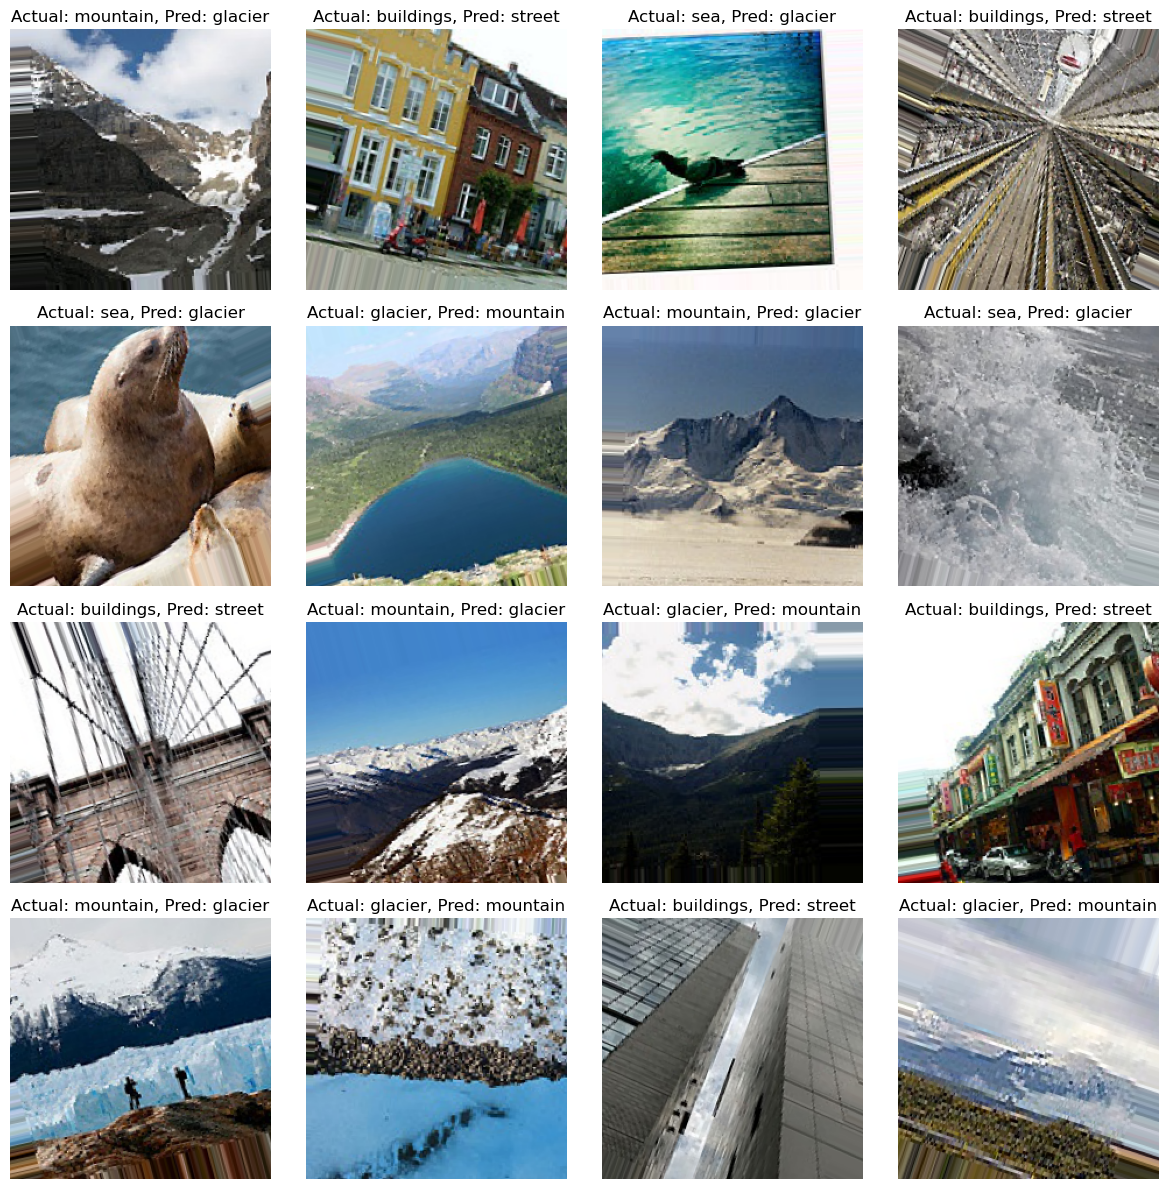

In [22]:
# find some incorrect image
incorrect_indices = np.nonzero(y_pred_label != y_true)[0]

if len(incorrect_indices) > 16:
    incorrect_indices = np.random.choice(incorrect_indices, 16, replace=False)

fig, ax = plt.subplots(4, 4, figsize=(12, 12))

for i, incorrect in enumerate(incorrect_indices):
    plt.subplot(4, 4, i + 1)
    
    img = test_gen[incorrect // batch_size][0][incorrect % batch_size]
    img = img * 255
    img = img.astype(np.uint8)
    
    plt.imshow(img)
    plt.title(f"Actual: {class_names[y_true[incorrect]]}, Pred: {class_names[y_pred_label[incorrect]]}")
    plt.axis("off")

plt.tight_layout()

# **Model Saving**

melkakukan model saving kedalam direktori yang dipilih

In [21]:
model.save('D:\Hacktiv8\Phase 2\Week 1\p2-ftds009-hck-g7-habibibagus123/model.h5')

# **Model Inference**

model inference ada di notebook lain

# **Kesimpulan**

kesimpulan yang didapat adalah didapatkan ke akurasian model adalah 88%. Terdapat kesalahan prediksi seperti yang bisa dilihat pada heatmap yang ditampilkan. Kesalahan prediksi dikarenakan gambar yang tidak jelas dan gambar terhalang sesuatu oleh karena itu prediksi menjadi salah